## Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from scipy import stats
from scipy.io import arff

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest, HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%matplotlib inline

## Load Data

In [ ]:
def load_data(input):
    ''' Iterates through the input directory and loads each .arff file corresponding to each forecasting period,
        renames the attributes with the correct column names,
        converts the class variable values from object type to binary (b'0' to 0 and b'1' to 1),
        and returns a dictionary of dataframes indexed by number of forecasting years'''

    dfs = {}

    column_mappings_df = pd.read_csv('./columns.csv')
    column_mappings_dict = dict(zip(column_mappings_df['attr'], column_mappings_df['column']))

    for index, file in enumerate(os.listdir(INPUT_DATA_PATH)):
        temp_df = pd.DataFrame(arff.loadarff(INPUT_DATA_PATH + file)[0])
        temp_df.rename(columns=column_mappings_dict, inplace=True)
        temp_df = temp_df.astype({'class': int})
        dfs[index + 1] = temp_df

    return dfs

In [ ]:
INPUT_DATA_PATH = './Data/'
dfs = load_data(INPUT_DATA_PATH)

## Data Summary

In [ ]:
def basic_counts(dfs):

    columns = ['Forecasting Year', 'Total records', 'Did Not Bankrupt', 'Went Bankrupt', 'Did Not Bankrupt %', 'Went Bankrupt %']
    counts_summary = []

    for index in dfs:
        temp_df = dfs[index]

        temp = []
        temp.append(index)
        temp.append(len(temp_df))
        temp.append(len(temp_df[temp_df['class'] == 0]))
        temp.append(len(temp_df[temp_df['class'] == 1]))
        temp.append(len(temp_df[temp_df['class'] == 0])/len(temp_df) * 100)
        temp.append(len(temp_df[temp_df['class'] == 1])/len(temp_df) * 100)

        counts_summary.append(temp)

    return pd.DataFrame(counts_summary, columns=columns)

def get_summary(df):
    return df.describe().T

def get_nulls_summary(df):
    return df.isnull().sum()

def plot_feature_histograms(df, bins):
    df.hist(bins=bins, figsize=(40, 20))
    plt.show()

def plot_box_plot(df, feature):
    sns.boxplot(x=feature, data=df)
    plt.show()

In [ ]:
basic_counts(dfs)

,Forecasting Year,Total records,Did Not Bankrupt,Went Bankrupt,Did Not Bankrupt %,Went Bankrupt %
0,1,10503,10008,495,95.287061,4.712939
1,2,7027,6756,271,96.143447,3.856553
2,3,9792,9277,515,94.740605,5.259395
3,4,10173,9773,400,96.068023,3.931977
4,5,5910,5500,410,93.062606,6.937394


## Pre-processing

In [ ]:
def remove_features(cutoff_percent, df):
    '''Removes feature if percentage of missing values > cutoff_percent'''

    missing_values_summary = df.isnull().sum().sort_values() / len(df)
    missing_values_summary = missing_values_summary.loc[lambda count : count > cutoff_percent]
    remove_features = missing_values_summary.index

    for feature in remove_features:
        df = df.drop(feature, axis=1)
        print('Removed:', feature)

    return df

def knn_impute(df, n_neighbours):
    imputer = KNNImputer(n_neighbors=n_neighbours)
    df_array = imputer.fit_transform(df)
    df = pd.DataFrame(df_array, columns=df.columns, index=df.index)
    return df

def mean_impute(df):
    df = df.fillna(df.mean())
    return df

def remove_outliers_by_z_score(df, feature, limits=[-3,3]):
    z_scores = stats.zscore(df[feature])
    outliers = (z_scores > limits[1]) | (z_scores < limits[0])
    df = df[~outliers]
    return df

def remove_outliers_by_isolation_forest(df, feature, contamination):
    clf = IsolationForest(contamination=contamination)
    outliers = clf.fit_predict(df[[feature]])
    outlier_values = df[feature][outliers == -1]

    return df[outliers != -1]

def scale_data_standard(X_train, X_test):
    std_scaler = StandardScaler()
    std_scaler.fit(X_train)
    X_train = pd.DataFrame(std_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(std_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    return X_train, X_test

def process_data(df, classifier, train_size=0.7, scale=False, scale_method='STANDARD'):
    y = df[classifier]
    X = df.drop(classifier, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=3)
    if scale:
      if (scale_method == 'STANDARD'):
          X_train, X_test = scale_data_standard(X_train, X_test)

    return X_train, X_test, y_train, y_test


In [ ]:
# First dataset - Forecasting Bankruptcy after 5 years
df = dfs[1]

In [ ]:
print('Before', len(df.columns))
df = remove_features(0.35, df)
print('After', len(df.columns))
df = knn_impute(df, 5)

Before 65
Removed: (current assets - inventories) / long-term liabilities
After 64


In [ ]:
features = df.columns

for feature in features:
    df = remove_outliers_by_z_score(df, feature, [-6,6])

len(df)

9375

In [ ]:
basic_counts({1: df})

,Forecasting Year,Total records,Did Not Bankrupt,Went Bankrupt,Did Not Bankrupt %,Went Bankrupt %
0,1,9375,8961,414,95.584,4.416


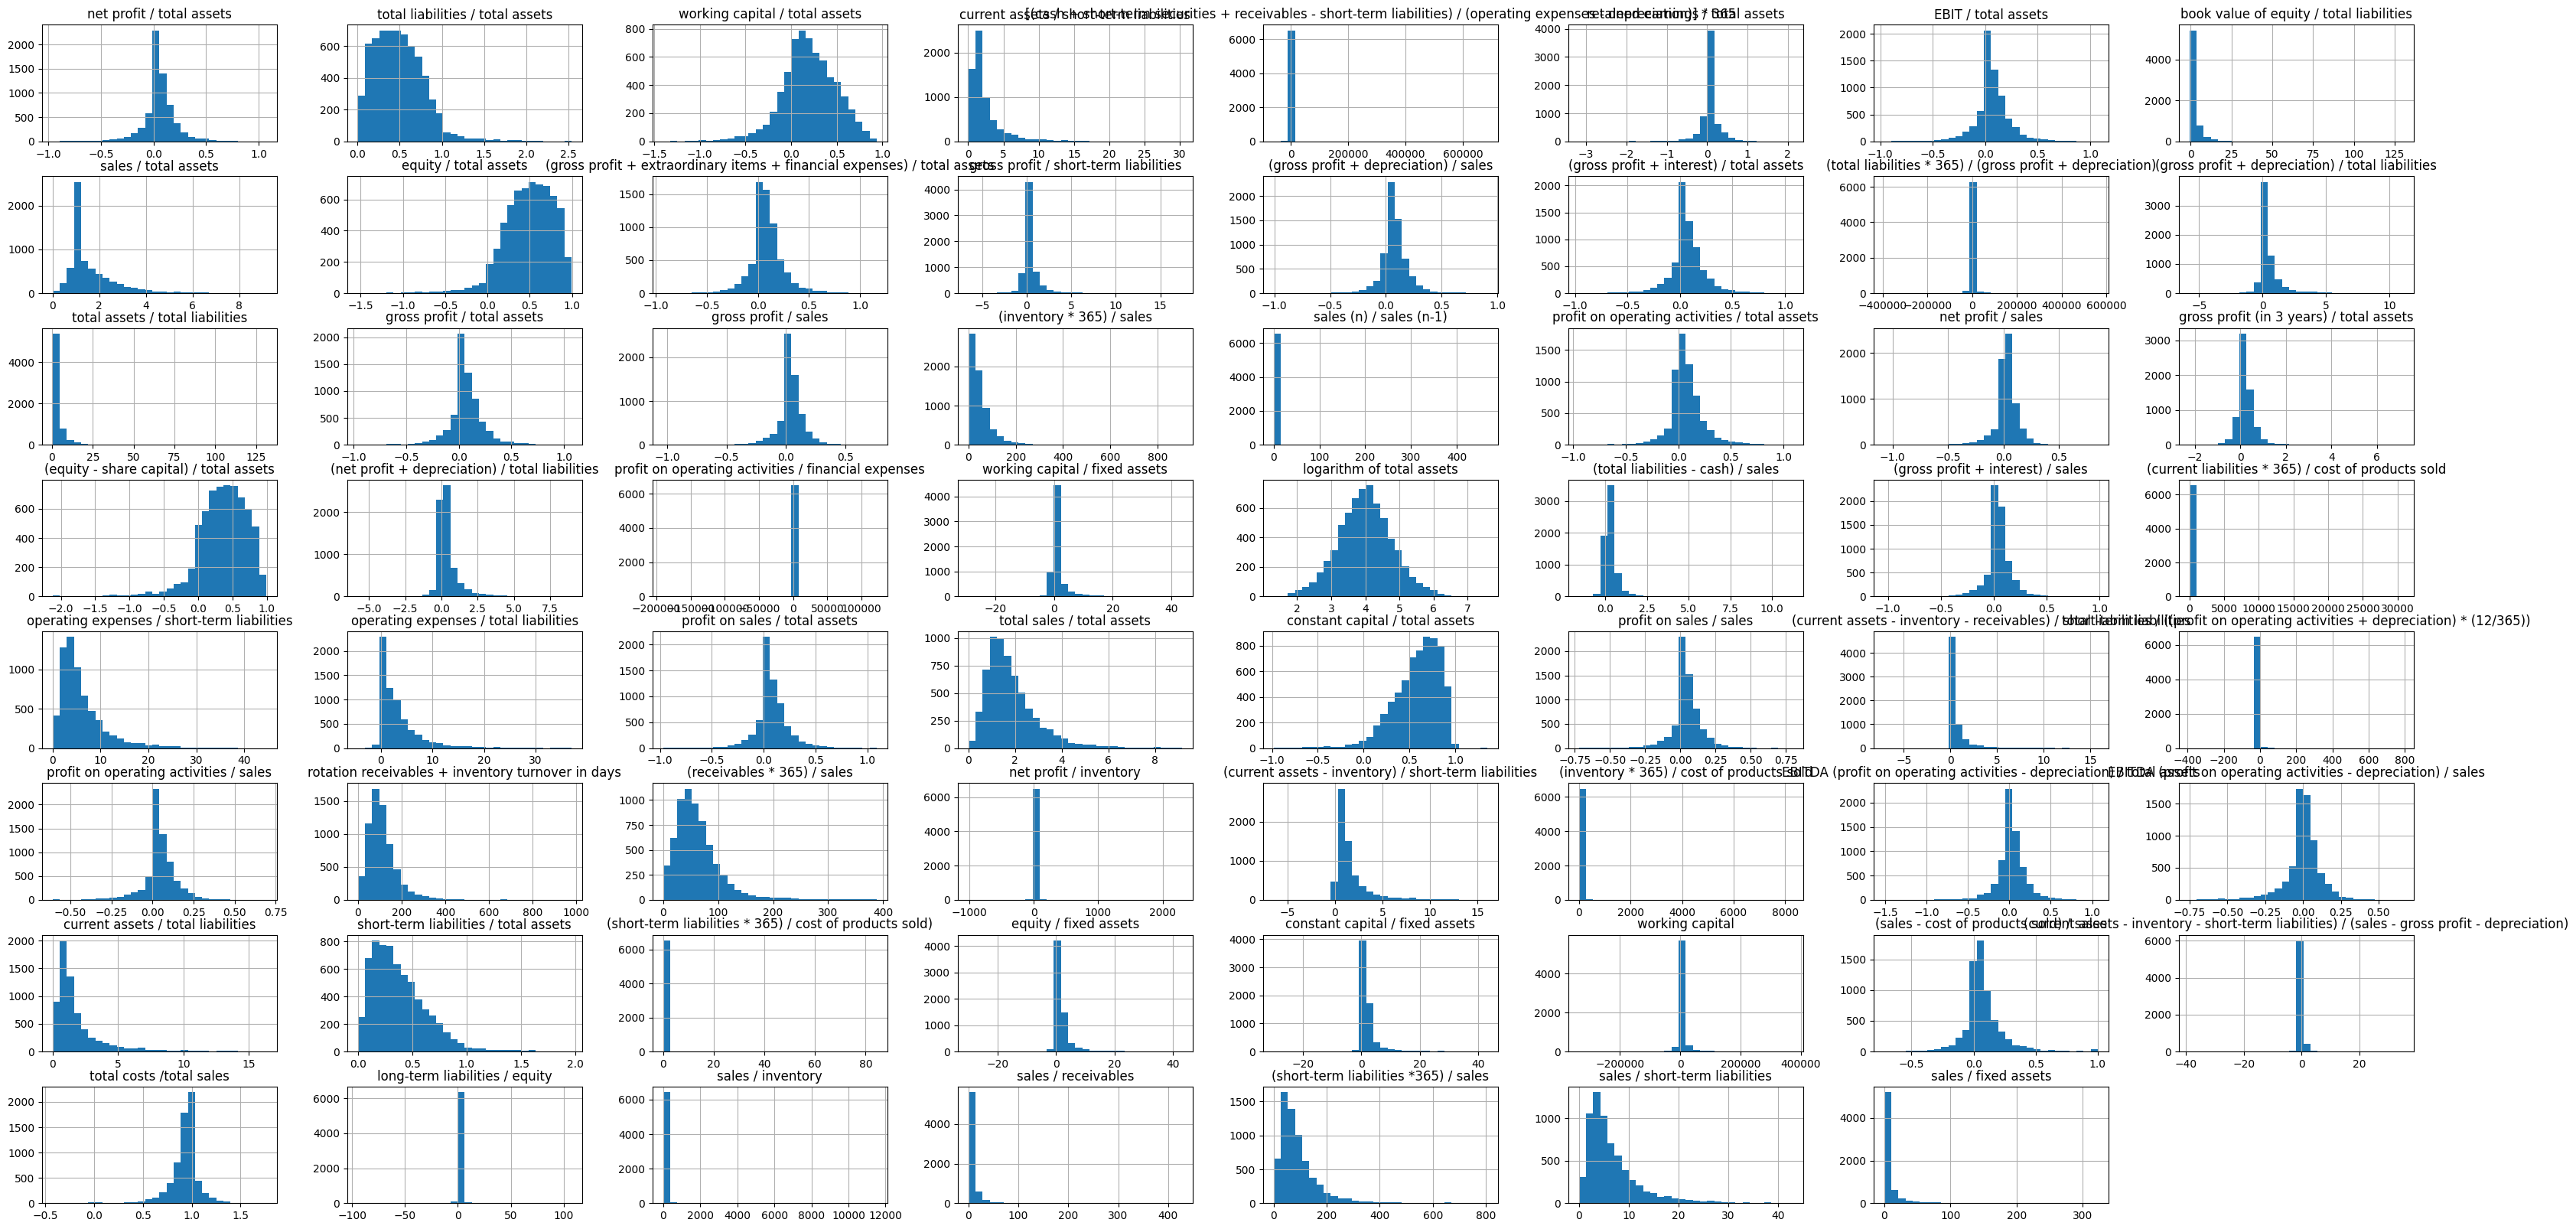

In [ ]:
X_train, X_test, y_train, y_test = process_data(df, 'class', 0.7)
X_train.head()

plot_feature_histograms(X_train, bins=30)

## Base Modelling

In [ ]:
def baseline(x):
    # Always predicts that the firm did not go bankrupt
    return 0

In [ ]:
y_train_baseline = X_train.apply(baseline, axis=1)
y_train_baseline.value_counts()

y_test_baseline = X_test.apply(baseline, axis=1)
y_test_baseline.value_counts()

baseline_train_accuracy = np.sum(y_train_baseline == y_train)/len(y_train)
baseline_test_accuracy = np.sum(y_test_baseline == y_test)/len(y_test)
print('Baseline Training Accuracy -', '{:.2f}%'.format(baseline_train_accuracy * 100))
print('Baseline Test Accuracy -', '{:.2f}%'.format(baseline_test_accuracy * 100))

Baseline Training Accuracy - 95.49%
Baseline Test Accuracy - 95.81%


In [ ]:
models = {
    #'Linear Regression': LinearRegression(),
    'K Neighbors Classifier': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Histogram Gradient Boosting Classifier': HistGradientBoostingClassifier()
}

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(name, '{:.2f}%'.format(accuracy * 100))

Linear Regression -45.27%
K Neighbors Classifier 95.63%
Decision Tree Classifier 92.68%
Random Forest Classifier 95.56%
Gradient Boosting Classifier 95.73%


In [ ]:
def build_model(hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):

  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())

  for hidden_layer_size in hidden_layer_sizes:
    model.add(keras.layers.Dense(units=hidden_layer_size, activation=activation))

  model.add(keras.layers.Dense(units=1, activation='sigmoid'))

  if optimizer == 'SGD':
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == 'Adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  else:
    raise ValueError("Invalid optimizer name provided")

  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
model = build_model([16, 32], activation='tanh', optimizer='Adam', learning_rate=0.001)

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=32,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

test_accuracy = model.evaluate(x=X_test, y=y_test, verbose=0, return_dict=True)['accuracy']

print('{:.2f}%'.format(test_accuracy * 100))

95.81%


## PCA

In [ ]:
def process_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(X_train)

    X_train_reduced = pd.DataFrame(pca.transform(X_train), index=X_train.index, columns=['PC-' + str(i) for i in range(1, n_components + 1)])
    X_test_reduced = pd.DataFrame(pca.transform(X_test), index=X_test.index, columns=['PC-' + str(i) for i in range(1, n_components + 1)])

    return X_train_reduced, X_test_reduced

In [ ]:
n_components = 10

X_train_reduced, X_test_reduced = process_pca(X_train, X_test, n_components)

X_train_reduced.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
0,-269.346515,1486.103843,-109.380200,222.089708,-72.459906,-45.137243,-40.469422,44.594568,43.227836,5.783970
1,-2811.774337,1695.555681,-41.946617,219.841404,-123.368095,-37.045684,-4.511395,129.425762,1.009216,36.305763
2,10456.651742,2157.558076,-121.105042,211.975479,-47.782783,-43.770130,-40.861605,42.218611,26.815658,15.905773
3,-2064.857809,1021.471899,-173.608221,218.947731,-28.927502,-41.544449,1.370223,23.470495,-2.983393,7.247760
4,-4454.973812,-424.451524,-205.682735,-260.175877,82.547040,-32.885759,64.828500,-20.952989,-57.912037,-7.627676


In [ ]:
X_train_reduced.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1,6562.0,-9.225231e-13,30333.566972,-341730.980218,-5648.021152,-4673.122728,-918.121195,366002.751117
PC2,6562.0,2.128900e-13,19396.371558,-395920.796896,-1871.594919,-1237.116931,186.864569,559494.498136
PC3,6562.0,-8.870415e-14,8887.054415,-59659.698691,-187.057271,-133.714009,-81.263404,685297.607623
PC4,6562.0,0.000000e+00,4874.816851,-121768.880859,254.237123,264.100065,268.477121,190398.723080
PC5,6562.0,2.217604e-15,504.433106,-576.167714,-74.332748,-38.980902,11.994148,30997.241938
PC6,6562.0,1.108802e-15,398.353756,-296.521194,-50.274025,-44.552258,-32.504480,11363.975652
PC7,6562.0,1.524603e-15,127.710974,-2729.690062,-46.197152,-20.103832,19.190133,5890.210321
PC8,6562.0,8.316014e-16,98.505786,-897.794368,-31.557657,18.681573,57.979364,1801.672533
PC9,6562.0,1.593903e-15,57.000839,-750.101021,-24.521893,0.802786,21.655097,1142.019187
PC10,6562.0,-2.425504e-15,43.702543,-453.300160,-19.566675,-0.697688,19.552738,843.518611


In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'K Neighbors Classifier': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train_reduced, y_train)
    accuracy = model.score(X_test_reduced, y_test)
    print(name, '{:.2f}%'.format(accuracy * 100))

model = build_model([16, 32], activation='tanh', optimizer='Adam', learning_rate=0.001)

history = model.fit(
    x=X_train_reduced,
    y=y_train,
    epochs=32,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

test_accuracy = model.evaluate(x=X_test_reduced, y=y_test, verbose=0, return_dict=True)['accuracy']

print('Neural Network', '{:.2f}%'.format(test_accuracy * 100))

Linear Regression 0.17%
K Neighbors Classifier 95.63%
Decision Tree Classifier 90.44%
Random Forest Classifier 95.45%
Gradient Boosting Classifier 95.63%
Neural Network 95.81%


## Handling the Imbalanced Dataset

In [ ]:
def balance_by_downsampling(df):

    df_majority = df[df['class']==0]
    df_minority = df[df['class']==1]

    df_majority_downsampled = resample(df_majority,
                                    replace=False,
                                    n_samples=len(df_majority),
                                    random_state=1234)

    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    return df_downsampled

def balance_by_upsampling(df):
    df_majority = df[df['class']==0]
    df_minority = df[df['class']==1]

    df_minority_upsampled = resample(df_minority,
                                    replace=True,
                                    n_samples=len(df_majority),
                                    random_state=1234)

    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled

def balance_by_smote(X_train, y_train, sampling_strategy=0.5):
    smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
    return smote.fit_resample(X_train, y_train)

def balance_by_down_and_up_sampling(df):
    df_split_1 = df[0:len(df)//2]
    df_split_2 = df[len(df)//2:]

    df_downsampled = balance_by_downsampling(df_split_1)
    df_upsampled = balance_by_upsampling(df_split_2)

    df = pd.concat([df_downsampled, df_upsampled])
    return df

In [ ]:
df = dfs[1]

print('Before', len(df.columns))
df = remove_features(0.35, df)
print('After', len(df.columns))
df = knn_impute(df, 5)

features = df.columns

for feature in features:
    df = remove_outliers_by_z_score(df, feature, [-6,6])

print(len(df))

X_train, X_test, y_train, y_test = process_data(df, 'class', 0.8)

Before 65
Removed: (current assets - inventories) / long-term liabilities
After 64
9375


In [ ]:
X_train, y_train = balance_by_smote(X_train, y_train)

In [ ]:
n_components = 63

X_train_reduced, X_test_reduced = process_pca(X_train, X_test, n_components)

X_train_reduced.head()

TypeError: ignored

In [ ]:
for name, model in models.items():
    model.fit(X_train_reduced, y_train)
    accuracy = model.score(X_test_reduced, y_test)
    print(name, '{:.2f}%'.format(accuracy * 100))

model = build_model([8, 16], activation='tanh', optimizer='Adam', learning_rate=0.001)

history = model.fit(
    x=X_train_reduced,
    y=y_train,
    epochs=32,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

test_accuracy = model.evaluate(x=X_test_reduced, y=y_test, verbose=0, return_dict=True)['accuracy']

print('Neural Network', '{:.2f}%'.format(test_accuracy * 100))

Linear Regression -1964.81%
K Neighbors Classifier 79.41%
Decision Tree Classifier 86.29%
Random Forest Classifier 95.25%
Gradient Boosting Classifier 92.69%
Neural Network 93.55%


In [ ]:
# HYPER PARAMETERS
REMOVE_MAJORITY_NULL_FEATURES = True
MAJORITY_NULL_PERCENTAGE_CUTOFF = 0.3
IMPUTE_METHOD = 'KNN'
KNN_IMPUTE_N_NEIGHBORS = 20
OUTLIER_REMOVAL_METHOD = 'ZSCORE' #'ISOLATIONFOREST'
Z_SCORE_LIMITS = [-6,6]
IF_CONTAMINATION = 0.5
SCALE = True
SCALE_METHOD = 'STANDARD' #'MEAN'
TRAIN_SIZE = 0.9
PERFORM_PCA = False
PCA_COMPONENTS = 20
BALANCE_DATASET = True
BALANCE_METHOD = 'DOWNANDUPCOMBINED' #'UPSAMPLING', #'SMOTE'
SMOTE_SAMPLING_STRATEGY = 0.8
NN_LAYERS = [8,16]
NN_ACTIVATION = 'tanh'
NN_OPTIMIZER = 'Adam'
NN_LEARNING_RATE = 0.01

hyper_parameters = [REMOVE_MAJORITY_NULL_FEATURES, MAJORITY_NULL_PERCENTAGE_CUTOFF, IMPUTE_METHOD, KNN_IMPUTE_N_NEIGHBORS, OUTLIER_REMOVAL_METHOD, Z_SCORE_LIMITS, IF_CONTAMINATION, SCALE, SCALE_METHOD, TRAIN_SIZE, PERFORM_PCA, PCA_COMPONENTS, BALANCE_DATASET, BALANCE_METHOD, SMOTE_SAMPLING_STRATEGY, NN_LAYERS, NN_ACTIVATION, NN_OPTIMIZER, NN_LEARNING_RATE]

In [ ]:
def run_models(df, hyper_parameters):

    result = []
    result.extend(hyper_parameters)

    if REMOVE_MAJORITY_NULL_FEATURES:
        print('Removing features that have a missing percentage greater than', MAJORITY_NULL_PERCENTAGE_CUTOFF)
        df = remove_features(MAJORITY_NULL_PERCENTAGE_CUTOFF, df)

    if (IMPUTE_METHOD == 'KNN'):
        print('Imputing missing values by KNN Impute')
        df = knn_impute(df, KNN_IMPUTE_N_NEIGHBORS)

    features = df.columns[0:-1]
    if (OUTLIER_REMOVAL_METHOD == 'ZSCORE'):
        print('Removing outliers by Z score')
        for feature in features:
          df = remove_outliers_by_z_score(df, feature, Z_SCORE_LIMITS)

    elif (OUTLIER_REMOVAL_METHOD == 'ISOLATIONFOREST'):
        print('Removing outliers by Isolation forest')
        for feature in features:
          df = remove_outliers_by_isolation_forest(df, feature, IF_CONTAMINATION)

    print('Performing train test split and scaling data')
    X_train, X_test, y_train, y_test = process_data(df, classifier='class', train_size=TRAIN_SIZE, scale=SCALE, scale_method=SCALE_METHOD)

    if PERFORM_PCA:
        print('Performing PCA')
        X_train, X_test = process_pca(X_train, X_test, n_components=PCA_COMPONENTS)

    if BALANCE_DATASET:
        if (BALANCE_METHOD == 'DOWNSAMPLING'):
            print('Balancing dataset by downsampling')
            temp = balance_by_downsampling(pd.concat([X_train, y_train], axis=1))
            y_train = temp['class']
            X_train = temp.drop('class', axis=1)

        elif (BALANCE_METHOD == 'UPSAMPLING'):
            print('Balancing dataset by upsampling')
            temp = balance_by_upsampling(pd.concat([X_train, y_train], axis=1))
            y_train = temp['class']
            X_train = temp.drop('class', axis=1)

        elif (BALANCE_METHOD == 'SMOTE'):
            print('Balancing dataset by smote')
            X_train, y_train = balance_by_smote(X_train, y_train, SMOTE_SAMPLING_STRATEGY)

        elif(BALANCE_METHOD == 'DOWNANDUPCOMBINED'):
            print('Balancing dataset by downsampling and upsampling')
            temp = balance_by_down_and_up_sampling(pd.concat([X_train, y_train], axis=1))
            y_train = temp['class']
            X_train = temp.drop('class', axis=1)

    for name, model in models.items():
        print('Training', name)
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        accuracy_str = '{:.2f}%'.format(accuracy * 100)
        result.append(accuracy_str)
        print(name, accuracy_str)

    model = build_model(NN_LAYERS, activation=NN_ACTIVATION, optimizer=NN_OPTIMIZER, learning_rate=NN_LEARNING_RATE)

    print('Fitting', 'Neural network')
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=32,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    test_accuracy = model.evaluate(x=X_test, y=y_test, verbose=0, return_dict=True)['accuracy']
    test_accuracy_str = '{:.2f}%'.format(test_accuracy * 100)
    result.append(test_accuracy_str)
    print('Neural Network', test_accuracy_str)

    return result

In [ ]:
df = dfs[1]
result = run_models(df, hyper_parameters)

Removing features that have a missing percentage greater than 0.1
Removed: (current assets - inventories) / long-term liabilities
Imputing missing values by KNN Impute
Removing outliers by Z score
Performing train test split and scaling data
Balancing dataset by downsampling and upsampling
Training Linear Regression
Linear Regression -150.99%
Training K Neighbors Classifier
K Neighbors Classifier 89.87%
Training Decision Tree Classifier
Decision Tree Classifier 92.11%
Training Random Forest Classifier
Random Forest Classifier 94.78%
Training Gradient Boosting Classifier
Gradient Boosting Classifier 94.24%
Fitting Neural network
Neural Network 92.00%


In [ ]:
result_columns = ['REMOVE_MAJORITY_NULL_FEATURES', 'MAJORITY_NULL_PERCENTAGE_CUTOFF', 'IMPUTE_METHOD', 'KNN_IMPUTE_N_NEIGHBORS', 'OUTLIER_REMOVAL_METHOD', 'Z_SCORE_LIMITS', 'IF_CONTAMINATION', 'SCALE', 'SCALE_METHOD', 'TRAIN_SIZE', 'PCA', 'PCA_COMPONENTS', 'BALANCE_DATASET', 'BALANCE_METHOD', 'SMOTE_SAMPLING_STRATEGY', 'NN_LAYERS', 'NN_ACTIVATION', 'NN_OPTIMIZER', 'NN_LEARNING_RATE']

for name in models.keys():
    result_columns.append(name)
result_columns.append('Neural Network')

results = []

In [ ]:
results.append(result)

In [ ]:
results_df = pd.DataFrame(results, columns=result_columns)
results_df

,REMOVE_MAJORITY_NULL_FEATURES,MAJORITY_NULL_PERCENTAGE_CUTOFF,IMPUTE_METHOD,KNN_IMPUTE_N_NEIGHBORS,OUTLIER_REMOVAL_METHOD,Z_SCORE_LIMITS,IF_CONTAMINATION,SCALE,SCALE_METHOD,TRAIN_SIZE,PCA,PCA_COMPONENTS,BALANCE_DATASET,BALANCE_METHOD,SMOTE_SAMPLING_STRATEGY,NN_LAYERS,NN_ACTIVATION,NN_OPTIMIZER,NN_LEARNING_RATE,Linear Regression,K Neighbors Classifier,Decision Tree Classifier,Random Forest Classifier,Gradient Boosting Classifier,Neural Network
0,False,0.35,KNN,5,,"[-6, 6]",0.5,True,STANDARD,0.8,False,10,True,UPSAMPLING,0.8,"[8, 16]",tanh,Adam,0.01,-7555.05%,86.29%,92.10%,95.05%,85.01%,80.01%
1,True,0.20,KNN,5,ZSCORE,"[-5, 5]",0.5,True,STANDARD,0.8,False,10,True,UPSAMPLING,0.8,"[8, 16]",tanh,Adam,0.01,-409.29%,87.15%,92.78%,95.49%,86.13%,86.75%
2,True,0.10,KNN,10,ZSCORE,"[-6, 6]",0.5,True,STANDARD,0.9,False,10,True,DOWNANDUPCOMBINED,0.8,"[8, 16]",tanh,Adam,0.01,-150.99%,89.87%,92.11%,94.78%,94.24%,90.19%
3,True,0.10,KNN,10,ZSCORE,"[-6, 6]",0.5,True,STANDARD,0.9,True,20,True,DOWNANDUPCOMBINED,0.8,"[8, 16]",tanh,Adam,0.01,-148.75%,90.62%,90.41%,94.56%,90.83%,84.97%
4,True,0.10,KNN,10,ZSCORE,"[-6, 6]",0.5,True,STANDARD,0.9,False,20,True,DOWNANDUPCOMBINED,0.8,"[8, 16]",tanh,Adam,0.01,-150.99%,89.87%,92.11%,94.78%,94.24%,92.00%


In [ ]:
df = dfs[1]
print(len(df))
print('Removing features that have a missing percentage greater than', 0.3)
df = remove_features(0.3, df)

# print('Removing outliers by Z score')
# features = df.columns[0:-1]
# for feature in features:
#     df = remove_outliers_by_z_score(df, feature, [-6,6])
# print(len(df))

df_0 = df[df['class'] == 0]
df_1 = df[df['class'] == 1]

y_0 = df_0['class']
X_0 = df_0.drop('class', axis=1)

y_1 = df_1['class']
X_1 = df_1.drop('class', axis=1)

print('Performing train test split')
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, train_size=0.8, random_state=3, shuffle=True)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, train_size=0.8, random_state=3, shuffle=True)

X_train = X_train_0.append(X_train_1)
X_test = X_test_0.append(X_test_1)
y_train = y_train_0.append(y_train_1)
y_test = y_test_0.append(y_test_1)

X_train = knn_impute(X_train, 10)
X_test = knn_impute(X_test, 10)

10503
Removing features that have a missing percentage greater than 0.3
Removed: (current assets - inventories) / long-term liabilities
Performing train test split


In [ ]:
print('Removing outliers by IF')
temp = pd.concat([X_train, y_train], axis=1)
features = temp.columns[0:-1]
for feature in features:
    temp = remove_outliers_by_isolation_forest(temp, feature, 0.001)
print(len(temp))

Removing outliers by IF
7902


In [ ]:
print('Balancing dataset by upsampling')
#temp = pd.concat([X_train, y_train], axis=1)

Balancing dataset by upsampling


In [ ]:
df_majority = temp[temp['class']==0]
df_minority = temp[temp['class']==1]

df_minority_upsampled = resample(df_minority,
                                    replace=True,
                                    n_samples=len(df_majority),
                                    random_state=1234)

temp = pd.concat([df_majority, df_minority_upsampled])

In [ ]:
y_train = temp['class']
X_train = temp.drop('class', axis=1)

In [ ]:
# df_split_1 = temp[0:len(temp)//2]
# df_split_2 = temp[len(temp)//2:]

# df_downsampled = balance_by_downsampling(df_split_1)
# df_upsampled = balance_by_upsampling(df_split_2)

# temp = pd.concat([df_downsampled, df_upsampled])

In [ ]:
for name, model in models.items():
    print('Training', name)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    accuracy_str = '{:.2f}%'.format(accuracy * 100)
    print(name, accuracy_str)

model = build_model([8,16], activation='tanh', optimizer='Adam', learning_rate=0.001)

print('Fitting', 'Neural network')
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=32,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

test_accuracy = model.evaluate(x=X_test, y=y_test, verbose=0, return_dict=True)['accuracy']
test_accuracy_str = '{:.2f}%'.format(test_accuracy * 100)
print('Neural Network', test_accuracy_str)

Training K Neighbors Classifier
K Neighbors Classifier 95.15%
Training Decision Tree Classifier
Decision Tree Classifier 91.96%
Training Random Forest Classifier
Random Forest Classifier 94.91%
Training Gradient Boosting Classifier
Gradient Boosting Classifier 95.15%
Training Histogram Gradient Boosting Classifier
Histogram Gradient Boosting Classifier 96.29%
Fitting Neural network
Neural Network 95.29%


In [ ]:
from sklearn.metrics import accuracy_score

hist_gb_model = HistGradientBoostingClassifier(max_iter=1000, random_state=42, max_depth=3)
hist_gb_model.fit(X_train, y_train)
y_pred = hist_gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100}')

Accuracy: 96.66825321275583


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2002
           1       0.87      0.34      0.49        99

    accuracy                           0.97      2101
   macro avg       0.92      0.67      0.74      2101
weighted avg       0.96      0.97      0.96      2101



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1997    5]
 [  65   34]]


In [ ]:
y_test_baseline = X_test.apply(baseline, axis=1)
baseline_test_accuracy = np.sum(y_test_baseline == y_test)/len(y_test)
print('Baseline Test Accuracy -', '{:.2f}%'.format(baseline_test_accuracy * 100))
cm = confusion_matrix(y_test, y_test_baseline)
print("Confusion Matrix:")
print(cm)

Baseline Test Accuracy - 95.29%
Confusion Matrix:
[[2002    0]
 [  99    0]]


In [ ]:
report = classification_report(y_test, y_test_baseline)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2002
           1       0.00      0.00      0.00        99

    accuracy                           0.95      2101
   macro avg       0.48      0.50      0.49      2101
weighted avg       0.91      0.95      0.93      2101

